# Activity 1: Radial Velocity Fitting

In this notebook, we will fit real RV data with the 2-body model developped in class. The goal of this activity is to:
- get a direct contact with real data
- extract orbital and planetary characteristics from fitted parameters
- understand various challenges when fitting RV data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Step 1: Get the data

Go to the NASA Exoplanet Archive (https://exoplanetarchive.ipac.caltech.edu/) and download the RV time series of 70 Virginis that has 98 points. Save it as "70-Vir.txt".

In the cell below, load the data into a pandas dataframe, print it, and plot the RV time series with uncertainty.

             HJD          RV    RV_err
0   2.449767e+06  -54.900002  5.150000
1   2.449769e+06  -52.340000  2.590000
2   2.449794e+06  251.170227  1.063376
3   2.450088e+06  -87.519997  2.220000
4   2.450089e+06  -92.339996  2.100000
..           ...         ...       ...
93  2.455229e+06  -90.227386  2.811621
94  2.455313e+06  113.382874  1.576105
95  2.455577e+06  -94.550003  2.320000
96  2.455603e+06  -54.139999  2.050000
97  2.455604e+06  -45.349998  2.550000

[98 rows x 3 columns]


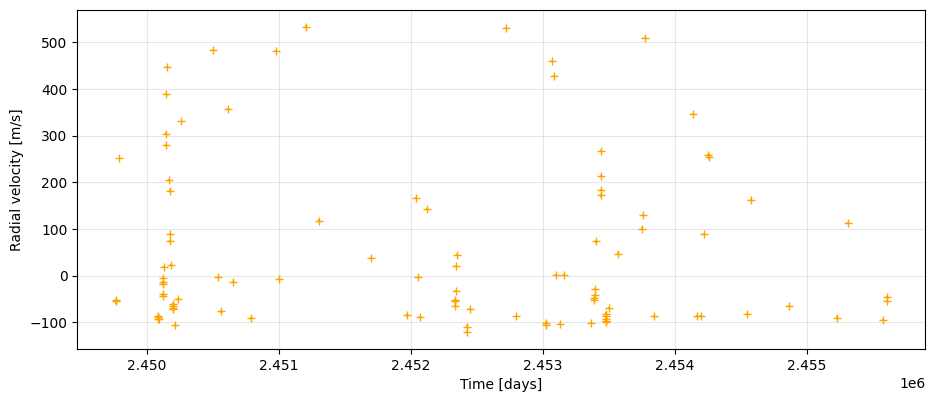

In [2]:
# Your code here

rv_data = pd.read_csv("70-Vir.txt",delimiter=r'\s+',skiprows=22,header=None,names=["HJD","RV","RV_err"])

# ---- Print ----
print(rv_data)

# ---- Plot ----
plt.errorbar(rv_data["HJD"],rv_data["RV"],yerr=rv_data["RV_err"],marker="+",c="orange",ls="")
plt.xlabel("Time [days]")
plt.ylabel("Radial velocity [m/s]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,4)
plt.show()

## Step 2: Evaluate parameters

Don't rush into the problem with your head down. Look at the data, try understanding what you see. What is the amplitude? Can you find the period? Can you estimate the time of passage at periastron? Can you get a sense of the eccentricity?

1. use the Lomb-Scargle tool to estimate the period

Zoom in on a cluster of points and analyze the shape:

2. The greater the eccentricity, the less it looks like a sine wave
3. The volume (fraction of the curve above or below average) gives information about the longitude $\omega$ (time at periastron)
    - if most of the curve is below the average value, $\omega$ is close to 0°, otherwise it is close to 180°
    - if the curve is symmetric, $\omega$ is close to 0° or 180°, otherwise it is close to 90° or 270°.

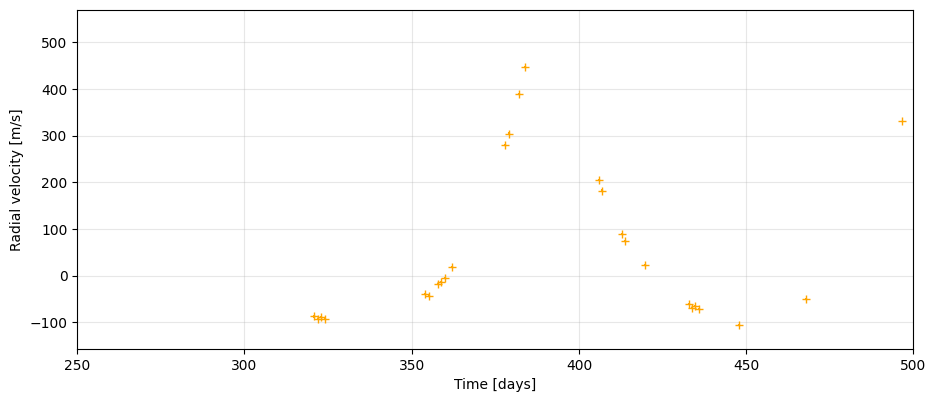

In [3]:
# Your code here

# ---- Plot ----
plt.errorbar(rv_data["HJD"]-rv_data["HJD"][0],rv_data["RV"],yerr=rv_data["RV_err"],marker="+",c="orange",ls="")
plt.xlabel("Time [days]")
plt.ylabel("Radial velocity [m/s]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,4)
plt.xlim(250,500)
plt.show()

In [4]:
# Define initial guesses here

P_init = 116.7 #days
K_init = np.ptp(rv_data["RV"])/2 #m/s
e_init = 0.5 #no units
omega_deg_init = 0.0 #degrees
Tp_init = 300.0 #days
Vz_init = np.mean(rv_data["RV"]) #m/s

## Step 3: Define the model to fit

We are going to use `scipy.optimize.curve_fit`, which requires to define functions as $f(x,p_1,p_2,...)$ where $x$ is the variable, and $p_i$ the parameters.

In [5]:
# The code in this cell has been generated with ChatGPT.
# Because of that, it was thoroughly reviewed and tested.
# Overall, it saved 1 hour of programming and required
# 10 minutes of review/testing, which is still a massive gain of time.
"""
Plot a single-planet radial velocity curve vs time.

RV model:
  v_r(t) = Vz + K [cos(omega + f(t)) + e cos(omega)]

where f(t) is the true anomaly derived from Kepler's equation.

Units:
  - time: days
  - P: period, same unit as time
  - K: semi-amplitude, m/s
  - omega_deg: longitude, degrees
  - Tp: time of periastron passage, same unit as time
  - Vz: m/s
"""

def solve_kepler(M, e, tol=1e-12, max_iter=100):
    """
    Solve Kepler's equation M(t) = E - e*sin(E) for eccentric anomaly E(t).

    Parameters
    ----------
    M : array_like
        Mean anomaly (radians)
    e : float
        Eccentricity (0 <= e < 1)
    """
    M = np.asarray(M)
    # Wrap to [-pi, pi] for better convergence
    M_wrapped = (M + np.pi) % (2 * np.pi) - np.pi

    if e == 0.0:
        return M_wrapped.copy()

    # Good initial guess
    E = np.where(e < 0.8, M_wrapped, np.pi * np.sign(M_wrapped))
    # Newton-Raphson
    for _ in range(max_iter):
        f = E - e * np.sin(E) - M_wrapped
        fp = 1 - e * np.cos(E)
        dE = -f / fp
        E = E + dE
        if np.max(np.abs(dE)) < tol:
            break
    return E


def true_anomaly_from_E(E, e):
    """Convert eccentric anomaly E to true anomaly f."""
    if e == 0.0:
        return E
    cosE = np.cos(E)
    sinE = np.sin(E)
    fac = np.sqrt(1 - e**2)
    # Use atan2 form for numerical stability
    f = np.arctan2(fac * sinE, cosE - e)
    return f


def rv_curve(t, P, K, e=0.0, omega_deg=0.0, Tp=0.0, Vz=0.0):
    """
    Compute radial velocity at times t.

    Parameters
    ----------
    t : array_like
        Times (same unit as P, Tp)
    P : float
        Period
    K : float
        Semi-amplitude (m/s)
    e : float
        Eccentricity
    omega_deg : float
        Argument of periastron (degrees)
    Tp : float
        Time of periastron passage
    Vz : float
        Systemic velocity (m/s)
    """
    omega = np.deg2rad(omega_deg)
    
    n = 2 * np.pi / P  # mean motion
    M = n * (t - Tp)   # mean anomaly (radians)
    E = solve_kepler(M, e)
    f = true_anomaly_from_E(E, e)
    return Vz + K * (np.cos(omega + f) + e * np.cos(omega))


def plot_rv(P=10.0, K=50.0, e=0.25, omega_deg=110.0, Tp=0.0, Vz=0.0,n_periods = 3,plot_show=True):

    # Time grid: cover a few periods
    t = np.linspace(0, n_periods * P, 2000)

    v = rv_curve(t, P=P, K=K, e=e, omega_deg=omega_deg, Tp=Tp, Vz=Vz)

    # ---- Plot ----
    plt.plot(t, v)
    plt.xlabel("Time [days]")
    plt.ylabel("Radial velocity [m/s]")
    plt.title(f"RV curve: P={P:.3g} d, K={K:.3g} m/s, e={e:.3g}, ω={omega_deg:.3g}°")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if plot_show: plt.show()


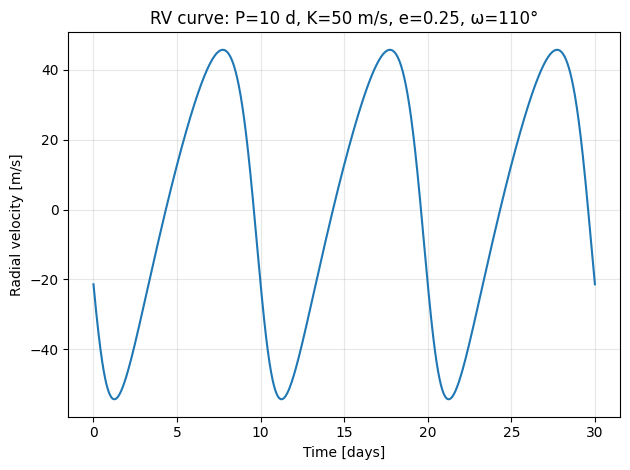

In [6]:
# plotting a RV curve with default parameters
plot_rv()

## Bonus Step: visualize intermediate quantities

Let's use this opportunity to plot how M, E and f actually look like

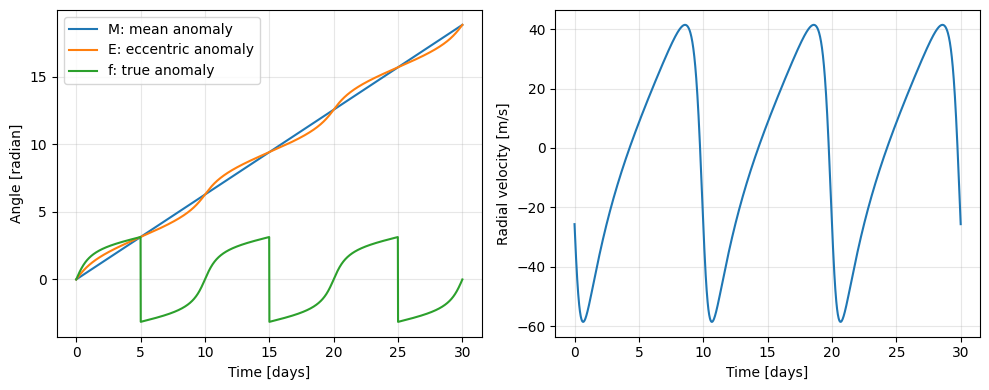

In [7]:
# We hide everything in a function so that everything
# is deleted from the memory when finished.
def visualize_step():
    # Define some parameters
    P_vis = 10.0
    K_vis = 50.0
    e_vis = 0.5
    omega_deg_vis = 110.0
    Tp_vis = 0.0
    Vz_vis = 0.0

    # Define time
    t = np.linspace(0, 3.0 * P_vis, 2000)

    # Mean motion
    n = 2 * np.pi / P_vis
    
    # Mean anomaly
    M = n * (t - Tp_vis)

    # Eccentric anomaly
    # Good initial guess
    E = M.copy()
    # Newton-Raphson
    for _ in range(100):
        g = E - e_vis * np.sin(E) - M
        gp = 1 - e_vis * np.cos(E)
        dE = -g / gp
        E = E + dE
        if np.max(np.abs(dE)) < 1e-12:
            break
            
    cosE = np.cos(E)
    sinE = np.sin(E)
    fac = np.sqrt(1 - e_vis**2)
    f = np.arctan2(fac * sinE, cosE - e_vis)

    omega_vis = np.deg2rad(omega_deg_vis)
    
    RV = Vz_vis + K_vis * (np.cos(omega_vis + f) + e_vis * np.cos(omega_vis))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

    ax1.plot(t,M,label="M: mean anomaly")
    ax1.plot(t,E,label="E: eccentric anomaly")
    ax1.plot(t,f,label="f: true anomaly")
    ax1.set_xlabel("Time [days]")
    ax1.set_ylabel("Angle [radian]")
    # ax1.set_title("RV curve: P={P} d, K={K} m/s, e={e}, ω={omega_deg}°")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(t,RV)
    ax2.set_xlabel("Time [days]")
    ax2.set_ylabel("Radial velocity [m/s]")
    # ax2.set_title(f"RV curve: P={P} d, K={K} m/s, e={e}, ω={omega_deg}°")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()    

# Run the visualization
visualize_step()

## Step 4: Fit the model to the data

In [8]:
# Your code here

# -------------------------------------------------------
# 1) Duplicating initial guess for easy access
# -------------------------------------------------------
P_init = 116.7 #days
K_init = np.ptp(rv_data["RV"])/2 #m/s
e_init = 0.5 #no units
omega_deg_init = 0.0 #degrees
Tp_init = 300.0 #days
Vz_init = np.mean(rv_data["RV"]) #m/s

# -------------------------------------------------------
# 2) Initial guesses
# -------------------------------------------------------
p_init = [
    P_init,           # P
    K_init,           # K
    e_init,           # e
    omega_deg_init,   # omega_deg
    Tp_init,          # Tp
    Vz_init           # Vz
]

# -------------------------------------------------------
# 3) Bounds (lower, upper)
# -------------------------------------------------------
lower_bounds = [
    1.0,      # P
    0.0,      # K
    0.0,      # e
    -360.0,   # omega_deg
    -np.inf,  # Tp
    -200.0    # Vz
]

upper_bounds = [
    300.0,    # P
    3000.0,   # K
    0.999,    # e
    520.0,    # omega_deg
    np.inf,   # Tp
    200.0     # Vz
]

# -------------------------------------------------------
# 4) Fit
# -------------------------------------------------------

x = rv_data["HJD"]-rv_data["HJD"][0]
y = rv_data["RV"]
yerr = rv_data["RV_err"]

param_opt, pcov = curve_fit(
    rv_curve,
    x,
    y,
    p0=p_init,
    bounds=(lower_bounds, upper_bounds),
    sigma=yerr,
    absolute_sigma=True
)

param_err = np.sqrt(np.diag(pcov))

# -------------------------------------------------------
# 5) Print comparison table
# -------------------------------------------------------
param_names = ["P", "K", "e", "omega [deg]", "Tp", "Vz"]

df = pd.DataFrame({
    "Parameter": param_names,
    "Initial guess": p_init,
    "Best fit": param_opt,
    "1σ uncertainty": param_err
})

display(df)

# Optional: also print nicely formatted
# print("\nBest-fit parameters:")
# for name, val, err in zip(param_names, popt, perr):
#     print(f"{name:12s} = {val: .6f} ± {err:.6f}")

,Parameter,Initial guess,Best fit,1σ uncertainty
0,P,116.700000,116.693557,0.001213
1,K,327.509998,313.517367,0.484508
2,e,0.500000,0.397386,0.001038
3,omega [deg],0.000000,-2.561772,0.155997
4,Tp,300.000000,272.919323,0.043538
5,Vz,56.593929,90.363563,0.228914


## Step 5: Validate your fit visually

Plot the data and the fit to visually validate that the fit worked as intended.

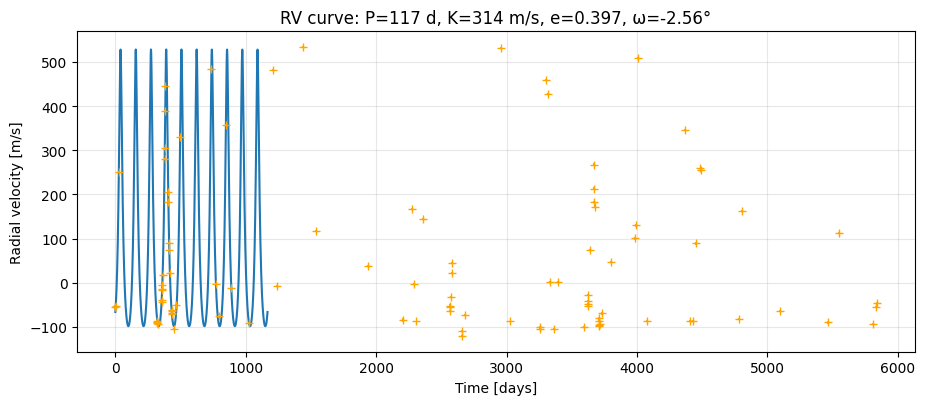

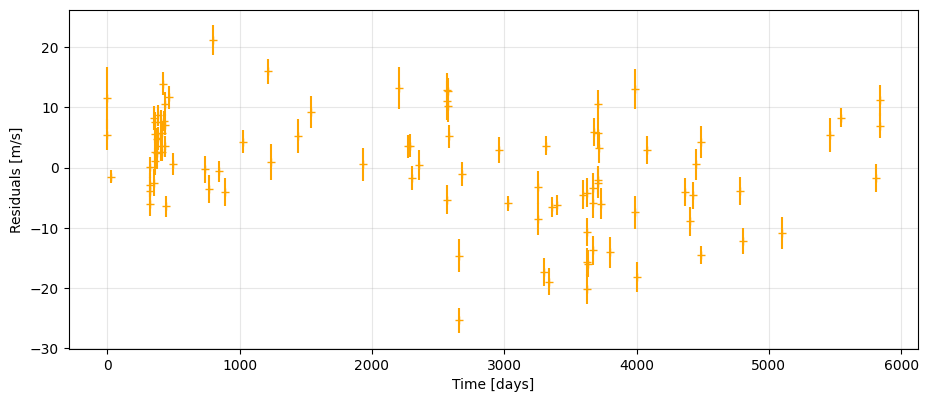

In [9]:
zoom_in = False

# ---- RV ----
plot_rv(*param_opt,n_periods=10,plot_show=False)
plt.errorbar(x,y,yerr=yerr,marker="+",c="orange",ls="")
plt.xlabel("Time [days]")
plt.ylabel("Radial velocity [m/s]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,4)
if zoom_in: plt.xlim(250,500)
plt.show()

# ---- Residuals ----
# Compute residuals
residuals = y - rv_curve(x,*param_opt)
# Plot residuals
plt.errorbar(x,residuals,yerr=yerr,marker="+",c="orange",ls="")
plt.xlabel("Time [days]")
plt.ylabel("Residuals [m/s]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,4)
if zoom_in: plt.xlim(250,500)
plt.show()

# Analysis: Robustness

We are happy because we obtained a result compatible with our expectations. However, here we are working with a very well-behaved and great quality dataset. This allowed to have clean initial guesses which helped the fitting significanlty. But what is the periodogram did not return a single strong signal? What if we couldn't estimate $\omega$ by eye?

Do some testing of your code to answer the following questions:

1. What parameters require a very good initial guess?
2. What parameters can be fitted robustly, even if they are far from the actual value?
3. Suppose the data quality is worse that what we have. Can you come up with a strategy that would extend the working range of this exercise?

________________________
Your answer here:<br><br>

K and Vz can be fitted quite robustly. e and omega too.<br>

P is the parameter that is the most difficult to fit. The reason is because a small variation in P over 1 period results in a huge variation in time over the whole RV time series (e.g. if P is changed by 1%, in the first period the time is shifted by 1%, but in the 10th period the time is shifted by 10%). Thankfully, we have the Lomb-Scargle diagrams (periodograms) to find P with excellent precision.<br>

Since we're always starting by calculating P with a Lomb-Scargle periodogram, the data can immediately be phase-folded. This helps 1) visually validating the presence of RV signals and 2) estimate initial guesses for all parameters using all the data (and not the data present in just one period).

We can estimate $\omega$ by computing the average value of the RV time series, and counting ow many points are above or below that value.

In a sine wave, the curve goes up and down the same amount of time. If the orbit is eccentric, a larger fraction of the RV curve will be going up or down. Computing the discrete derivative $(RV_2-RV_1)/(t_2-t_1)$ for all intervals and making a histogram, it is possible to roughly evaluate the eccentricity.<br>

Aside from initial guesses, major improvements come from the fitting algorithm. The \texttt{scipy.optimize.curve_fit} function uses various fitting algorithms that are suitable for general problems, however they can be easily stuck in local minima (generally setting K=0 and claiming it has found a good local solution...). Therefore, it is critical to 1) either have initial guesses that are close to the expected solution or 2) if the expected solution is not trivial, explore a large parameter space with a different algorithm, for example with MC or MCMC.
________________________

## Step 6: Phase folded curve

RV points can be taken over the course of hundreds of periods, making it very inconvenient to show on a single figure. Once the period of the planet is known, a common procedure is to show the "phase-folded" diagram radial velocity curve, so that the quality of the fit can be evaluated while looking at only one period. In the cell below, plot the phase-folded RV curve and residuals.

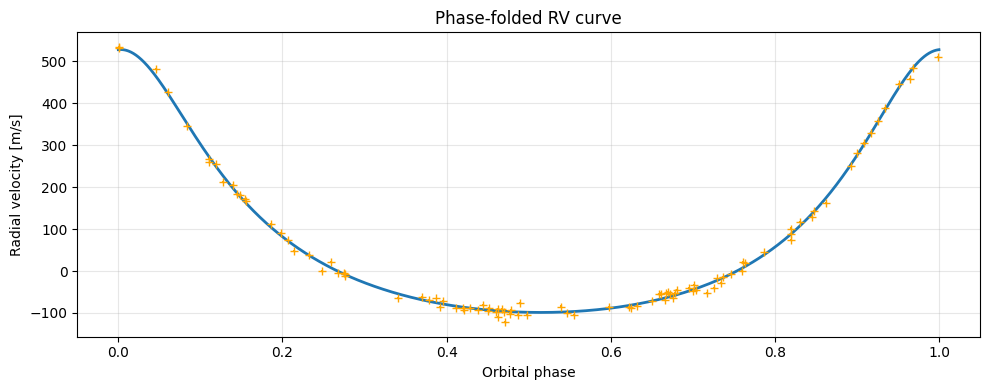

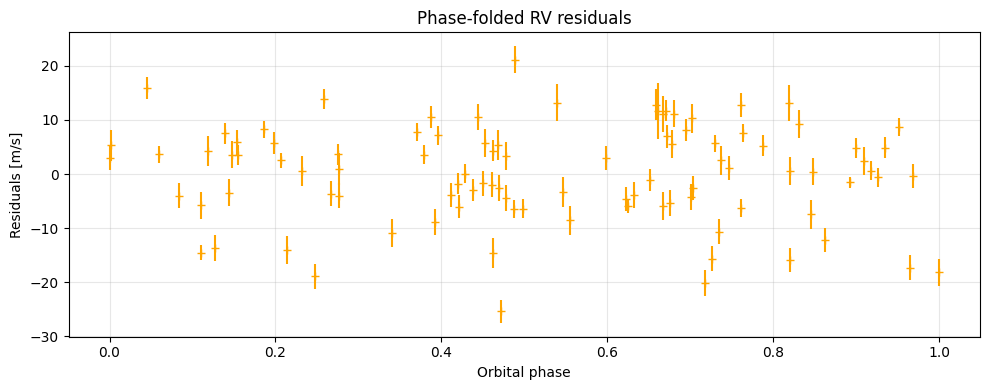

In [10]:
# Unpack best fit parameters
P_opt = param_opt[0]
K_opt = param_opt[1]
e_opt = param_opt[2]
omega_deg_opt = param_opt[3]
Tp_opt = param_opt[4]
Vz_opt = param_opt[5]

# ---- compute phase ----
# Using Tp (time of periastron) as the reference epoch:
phase = ((x - Tp_opt) / P_opt) % 1.0              # in [0, 1)

# ---- model curve sampled finely ----
phase_grid = np.linspace(0, 1, 2000)
t_grid = Tp_opt + phase_grid * P_opt

# ---- sort data by phase for nicer plotting ----
order = np.argsort(phase)

# ---- Plot ----
plt.figure(figsize=(10,4))

rv_model = rv_curve(t_grid, P_opt, K_opt, e=e_opt, omega_deg=omega_deg_opt, Tp=Tp_opt,Vz=Vz_opt)
plt.plot(phase_grid, rv_model, linewidth=2)

plt.errorbar(
    phase[order], y[order], yerr=yerr[order],
    marker="+",c="orange",ls=""
)
plt.xlabel("Orbital phase")
plt.ylabel("Radial velocity [m/s]")
plt.title("Phase-folded RV curve")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Residuals ----
plt.figure(figsize=(10,4))
rv_model = rv_curve(x, P_opt, K_opt, e=e_opt, omega_deg=omega_deg_opt, Tp=Tp_opt,Vz=Vz_opt)
plt.errorbar(
    phase[order], y[order] - rv_model[order], yerr=yerr[order],
    marker="+",c="orange",ls=""
)

plt.xlabel("Orbital phase")
plt.ylabel("Residuals [m/s]")
plt.title("Phase-folded RV residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Final step: Back to the physics -- calculating the mass of 70 Vir b

Time to collect the fruit of our labor!

Our analysis proves the existence of a companion that is massive enough to affect the motion of its host star 70 Vir, but is too faint to be visible by a telescope.

1. Given $K = \frac{28.4329\mathrm{m.s^{-1}}}{\sqrt{1-e^2}} \left(\frac{m_2\sin i}{M_\mathrm{Jup}}\right) \left(\frac{m_1 + m_2}{M_\odot}\right)^{-1/2} \left(\frac{P}{\text{1 yr}}\right)^{-1/3}$ invert the relation to explicit $m_2 \sin i$ as a function of parameters of the fit, assuming $m_2 \ll m_1$.
2. Explicit the uncertainty $\sigma_{m_2 \sin i}$ as a function of parameters of fit. We remind:
   - if $f = kA^a B^b$, then $\sigma_f \approx \left| f \right| \sqrt{ \left(a\frac{\sigma_A}{A}\right)^2 + \left(b\frac{\sigma_B}{B}\right)^2 }$
   - if $f = \sqrt{1-A^2}$, then $\sigma_f = \left| \frac{\sigma_A A}{f} \right|$
3. Calculate $m_2 \sin i$ with its uncertainty, and conclude on the nature of the exoplanet 70 Vir b.
4. Which quantity corresponds to the largest source of uncertainty for $m_2 \sin i$? Discuss the assumption $m_2 \ll m_1$.

In [23]:
# Your code below

# Formula to get m2 sin i
def calc_m2sini(P,K,e,m1):
    # P in days
    # K in m/s
    # e no units
    # m1 in Msun
    P_years = P/365.25
    return (K/28.4329) * np.sqrt(1.0-e**2) * (m1)**0.5 * (P_years)**(1.0/3.0)

# Formula to get uncertainty on m2 sin i
def calc_sigma_m2sini(P,K,e,m1,dP,dK,de,dm1,print_indiv=False):
    # P,dP in days
    # K,dK in m/s
    # e,de no units
    # m1,dm1 in Msun

    # handling eccentricity
    e_sqrt = np.sqrt(1.0-e**2)
    sigma_e_sqrt = np.abs(e*de)/e_sqrt

    # computing the rest
    m2sini = calc_m2sini(P,K,e,m1)
    sigma_m2sini = m2sini * np.sqrt( (dK/K)**2 + (sigma_e_sqrt/e_sqrt)**2 + (0.5*dm1/m1)**2 + (1.0/3.0*dP/P)**2 )
    
    # Relative uncertainty of individual terms:
    if print_indiv: print((dK/K), (sigma_e_sqrt/e_sqrt), (0.5*dm1/m1), (1.0/3.0*dP/P))
    return sigma_m2sini
    

P_opt = param_opt[0]
K_opt = param_opt[1]
e_opt = param_opt[2]
m1 = 1.06055007396500

dP_opt = param_err[0]
dK_opt = param_err[1]
de_opt = param_err[2]
dm1 = 0.02910211509607 

m2sini = calc_m2sini(P_opt,K_opt,e_opt,m1)
sigma_m2sini = calc_sigma_m2sini(P_opt,K_opt,e_opt,m1,dP_opt,dK_opt,de_opt,dm1)

print(f'The mass of 70 Vir b is m_2 sin i = {m2sini:.3f} ± {sigma_m2sini:.3f} M_Jup. It'+"'"+f's a super-Jupiter.')
print()

calc_sigma_m2sini(P_opt,K_opt,e_opt,m1,dP_opt,dK_opt,de_opt,dm1,print_indiv=True)
print("The largest source of uncertainty comes from the uncertainty in the host star mass")
print() 

m_jup_in_sun = 0.00095
print(f'm2 sin i = {m2sini*m_jup_in_sun} M_sun. This is '+
      f'much smaller than the mass of the host star, and is '+
      f'smaller than uncertainty of the host star mass dm1/m1.')

The mass of 70 Vir b is m_2 sin i = 7.124 ± 0.098 M_Jup. It's a super-Jupiter.

0.0015453939749877912 0.0004896060336102586 0.013720292803935262 3.4654971218775136e-06
The largest source of uncertainty comes from the uncertainty in the host star mass

m2 sin i = 0.006767469943562477 M_sun. This is much smaller than the mass of the host star, and is smaller than uncertainty of the host star mass dm1/m1.


## Conclusion

This is it. You now know how to fit RV data to recover planetary masses.

The concept is simple, but observers are constantly seeking ways to extract as much information as possible from the data. The tools must also be efficient, robust, and versatile.

For this reason, astronomers develop open source software to be used by the community (e.g. RadVel: https://radvel.readthedocs.io/en/latest/).